In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Import module from folder in another directory
import importlib.util
spec = importlib.util.spec_from_file_location("outliers", "data_preprocessing/outliers.py")
outliers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(outliers)
from sklearn.preprocessing import Imputer, StandardScaler

import sys
sys.path.append('data_preprocessing')
import data_preprocessing.summary as summary
import data_preprocessing.normalize as normalize

import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
#import xgboost as xgb

%matplotlib inline

rng = np.random.RandomState(31337)

In [34]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

geo_train_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
geo_test_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
train_data.columns
columns_isnull = []
for col in train_data.columns:
    isnul = train_data[col].isnull().sum()
    lendth = len(train_data[col])
    il = isnul/lendth
    if il >= .5:
        columns_isnull.append(col)
print("Columns that have more nulls: {}".format(columns_isnull))

Columns that have more nulls: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [35]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data
train_data = normalize.handle_missing_data(train_data)

train_data = normalize.remove_correlated_features(train_data)
#train_data = normalize.normalize(train_data)

train_data = outliers.remove_outliers(train_data)
train_data = train_data.drop( 'Id', 1)
train_data = train_data.drop('PID', 1)

# train_data = train_data.drop('BsmtFinSF2', 1)
# train_data = train_data.drop('3SsnPorch', 1)
# train_data.shape

Index(['Id', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive',

In [37]:
train_data.columns
train_data = train_data.drop('BsmtFinSF2', 1)
train_data = train_data.drop('3SsnPorch', 1)
train_data = train_data.drop('MiscVal', 1)
train_data = train_data.drop('LowQualFinSF', 1)
train_data = train_data.drop('YrSold', 1)
train_data = train_data.drop('PoolArea', 1)
train_data = train_data.drop('MoSold', 1)
train_data = train_data.drop('BsmtHalfBath', 1)
train_data = train_data.drop('ScreenPorch', 1)

List the numerical features in decending order by their correlation with Sale Price:

OverallQual: 	0.8099958863724778
GrLivArea: 	0.7168707951947251
GarageCars: 	0.6651278350651294
1stFlrSF: 	0.6477492517890527
YearBuilt: 	0.5664495990275107
FullBath: 	0.5600189094210655
YearRemodAdd: 	0.5388272318889644
MasVnrArea: 	0.4770503975542221
Fireplaces: 	0.46898909049853893
BsmtFinSF1: 	0.4128728639189717
LotArea: 	0.3921284328373953
LotFrontage: 	0.3678588409716765
OpenPorchSF: 	0.3314353805227873
WoodDeckSF: 	0.32332092788116695
HalfBath: 	0.28334339925768137
2ndFlrSF: 	0.2586053666655979
BsmtFullBath: 	0.2575460425455408
BsmtUnfSF: 	0.21987186213491086
BedroomAbvGr: 	0.1479246655093692
OverallCond: 	-0.1252464831769451
KitchenAbvGr: 	-0.12284318639926038
EnclosedPorch: 	-0.11586245102356443


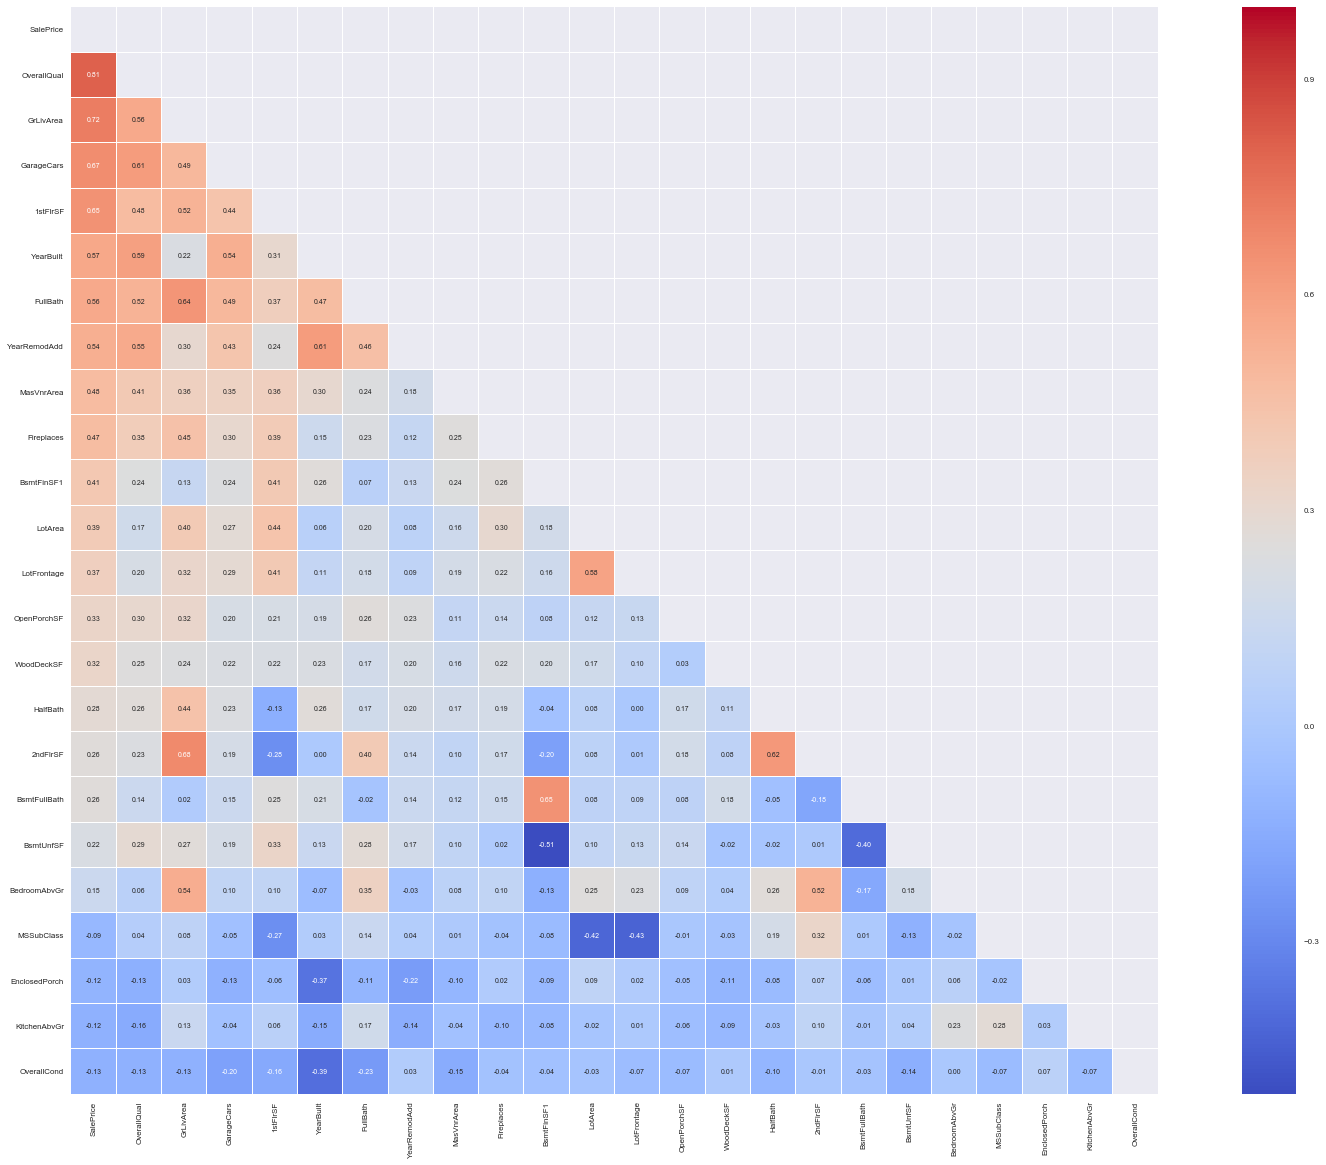

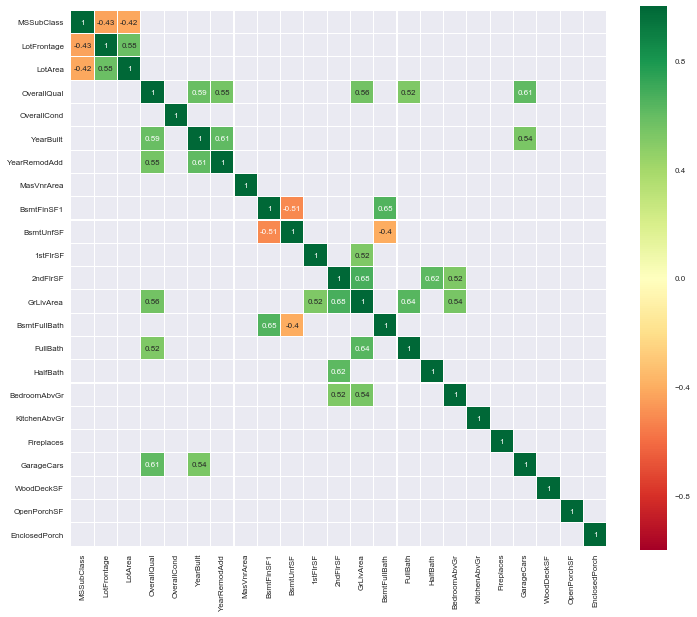

In [38]:
# train_data = outliers.remove_outliers(train_data)
# train_data.columns

# train_data.shape

# Correlations to SalePrice
corr = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['SalePrice'].to_dict()
del cor_dict['SalePrice']
print("List the numerical features in decending order by their correlation with Sale Price:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))
    
#Correlation matrix heatmap
corrmat = train_data.corr()
plt.figure(figsize=(30, 20))

#number of variables for heatmap
k = 76
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)

#generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=.80)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 7}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

#Feature-to-Feature Correlation
corr = train_data.drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='RdYlGn', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


In [39]:
train_data = train_data.select_dtypes(include=[np.number])
test_data = test_data.select_dtypes(include=[np.number])
train_data.head()
test_data.head()
X_train, X_test, y_train, y_test = train_test_split(train_data.loc[:, train_data.columns != 'SalePrice'], 
                                                  train_data['SalePrice'],
                                                  test_size=0.3, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

train_data.shape


(2306, 24)

In [40]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
clf.score(X_test, y_test)

0.89630555061911299